In [1]:
# Time series for deep-fjord temperature (Ts)
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
depth = xr.open_dataset('/work/oceans/wbao/MITgcm_results/iceplume/Sal_Linear_minhs/state_001.nc').Z.data
print(depth[21])

In [2]:
def deep_fjord_temp(datapath, case_id, xid, sid):
    

    State0 = xr.open_dataset(datapath+'/state_' + str(format(case_id,'03d')) + '.nc')
    Grid = xr.open_dataset(datapath+'/grid_' + str(format(case_id,'03d')) + '.nc')
    State = State0.isel(T=~State0.get_index("T").duplicated())    
    # Confine to the range of fjord
    state = State.isel(X=range(260), Xp1=range(261), Y=range(35,45), T=range(1,len(State.T)))
    grid = Grid.isel(X=range(260), Xp1=range(261), Y=range(35,45))
    
    #depth = state.Z.data
    U = (state.U.data[:,:,:,1:] + state.U.data[:,:,:,:-1]) / 2
    Uymean = U.mean(2)
    T = state.Temp.data.mean(2) # Average in Y direction
    Day = state.T.data / 86400
    #S = state.S.data
    #sma = np.ma.masked_where(S==0, S)
    #topo = np.ma.getmask(sma) # Masked Topography
    #Uma = np.ma.MaskedArray(U, mask=topo)
    #Tma = np.ma.MaskedArray(T, mask=topo)
    
    drF = np.broadcast_to(grid.drF.data[np.newaxis, :, np.newaxis, np.newaxis], U.shape)
    dyF = np.broadcast_to(grid.dyF.data[np.newaxis, np.newaxis, :, :], U.shape)
    HFacC = np.broadcast_to(grid.HFacC.data[np.newaxis, :, :, :], U.shape)
    DA = drF * dyF * HFacC
    
    #rA = np.broadcast_to(grid.rA.data[np.newaxis, np.newaxis, :, :], U.shape)
    #CV = rA * drF * HFacC
    u_steady = Uymean[89:,:,:].mean(0)
    u_neg = np.where(u_steady[:,xid] < 0)[-1] # find the negative along-fjord velocity
    #l = u_neg[u_neg>=sid].min() # locate the layer interface below the sill depth[7]=-15m 
    l = sid
    da = DA.mean(2)
    
    Ts = np.empty(U.shape[0])
    for t in range(U.shape[0]):
        
        #Ts[t] = np.sum(T[t,l:,xid]*da[t,l:,xid]*Uymean[t, l:,xid]) / np.sum(da[t,l:,xid]*Uymean[t,l:,xid])
        Ts[t] = np.sum(T[t,l:,xid]*da[t,l:,xid]) / np.sum(da[t,l:,xid])
        
    
    return Ts

In [7]:
path1 = '/work/oceans/wbao/MITgcm_results/iceplume/Sal_Linear_minhs'
path2 = '/work/oceans/wbao/MITgcm_results/iceplume/Sal_Linear_maxhs'

path3 = '/work/oceans/wbao/MITgcm_results/iceplume/Sal_Linear_nosill'
S0, S1 = 6, 120
day = np.arange(0.5, 60.5, 0.5)

# TsS01 = vol_temp(path1, 1, S0)
# TsS02 = vol_temp(path1, 2, S0)
# TsS03 = vol_temp(path1, 3, S0)
# TsS04 = vol_temp(path1, 4, S0)
# TsS05 = vol_temp(path1, 5, S0)

# TsS11 = vol_temp(path1, 1, S1)
# TsS12 = vol_temp(path1, 2, S1)
# TsS13 = vol_temp(path1, 3, S1)
# TsS14 = vol_temp(path1, 4, S1)
# TsS15 = vol_temp(path1, 5, S1)

# Ts2S11 = vol_temp(path2, 1, S1)
# Ts2S12 = vol_temp(path2, 2, S1)
# Ts2S13 = vol_temp(path2, 3, S1)
# Ts2S14 = vol_temp(path2, 4, S1)
# Ts2S15 = vol_temp(path2, 5, S1)

Ts1 = deep_fjord_temp(path1, 5, S0, 7) # Regime 1
Ts2 = deep_fjord_temp(path2, 4, S0, 21) # Regime 2
Ts3 = deep_fjord_temp(path1, 1, S0, 7) # Regime 3 & 4
Ts4 = deep_fjord_temp(path1, 3, S0, 7) # Regime 1, 3

In [ ]:
#np.arange(0.5,60.5,0.5), day
Ts2S15

In [ ]:
# Making time-series plot
fig0 = plt.figure(figsize=(10,5))
fig0.tight_layout()

# Plot Ts at section S0
ax1 = fig0.add_subplot(211)
    
ax1.plot(day,TsS15,label=r'$0.5N_0^2$')
ax1.plot(day,TsS14,label=r'$1N_0^2$')
ax1.plot(day,TsS13,label=r'$2N_0^2$')
ax1.plot(day,TsS12,label=r'$3N_0^2$')
ax1.plot(day,TsS11,label=r'$4N_0^2$')
ax1.legend(loc='center left',fontsize=10)
    
#ax1.axvline(x=0,color='k',linestyle=':')
#ax1.set_xlabel(r'Time [days]', size=15)
ax1.xaxis.set_visible(False)
ax1.set_ylabel(r'Temperature [$^\circ C$]', size=15)
ax1.set_title('(a) $h_s/h=0.04$', loc='left', size=15, weight='bold')
ax1.tick_params(direction='in', labelsize=15)
ax1.set_ylim(8.5,10)

# Plot Ts at section S1
ax2 = fig0.add_subplot(212)
    
ax2.plot(day,Ts2S15,label=r'$0.5N_0^2$')
ax2.plot(day,Ts2S14,label=r'$1N_0^2$')
ax2.plot(day,Ts2S13,label=r'$2N_0^2$')
ax2.plot(day,Ts2S12,label=r'$3N_0^2$')
ax2.plot(day,Ts2S11,label=r'$4N_0^2$')
#ax2.legend(loc='best',fontsize=15)
    
#ax1.axvline(x=0,color='k',linestyle=':')
ax2.set_xlabel(r'Time [days]', size=15)
ax2.set_ylabel(r'Temperature [$^\circ C$]', size=15)
ax2.set_title('(b) $h_s/h=1$', loc='left', size=15, weight='bold')
ax2.tick_params(direction='in', labelsize=15)
ax2.set_ylim(8.5,10)

In [ ]:
day[19]

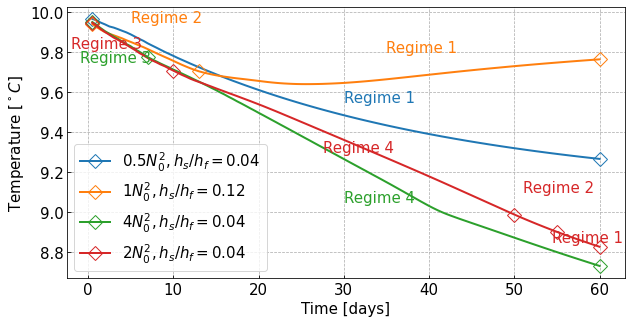

In [8]:
# Making time-series plot
fig1 = plt.figure(figsize=(10,5))
fig1.tight_layout()

ax1 = fig1.add_subplot(111)
    
ax1.plot(day,Ts1,'-D', fillstyle='none',markersize=10, markevery = [0, 119], lw=2, label=r'$0.5N_0^2,h_s/h_f=0.04$')
ax1.plot(day,Ts2,'-D', fillstyle='none',markersize=10, markevery = [0, 25, 119], lw=2,label=r'$1N_0^2,h_s/h_f=0.12$')
ax1.plot(day,Ts3,'-D', fillstyle='none',markersize=10, markevery = [0, 13, 119], lw=2,label=r'$4N_0^2,h_s/h_f=0.04$')
ax1.plot(day,Ts4, '-D', fillstyle='none',markersize=10, markevery = [0, 19, 99, 109, 119], lw=2,label=r'$2N_0^2,h_s/h_f=0.04$')
ax1.legend(loc='best',fontsize=15)

# case1
plt.text(30, 9.55, r'Regime 1', fontsize=15, color='#1f77b4')
# case2
plt.text(5, 9.95, r'Regime 2', fontsize=15, color='#ff7f0e')
plt.text(35, 9.8, r'Regime 1', fontsize=15, color='#ff7f0e')
# case3
plt.text(-1, 9.75, r'Regime 3', fontsize=15, color='#2ca02c')
plt.text(30, 9.05, r'Regime 4', fontsize=15, color='#2ca02c')
# case4
plt.text(-2, 9.82, r'Regime 3', fontsize=15, color='#d62728')
plt.text(27.5, 9.3, r'Regime 4', fontsize=15, color='#d62728')
plt.text(51, 9.1, r'Regime 2', fontsize=15, color='#d62728')
plt.text(54.4, 8.85, r'Regime 1', fontsize=15, color='#d62728')
# ax1.vlines(x = [0, 60], ymin = 8.5, ymax = 10, ls='--', color='#1f77b4')
# ax1.vlines(x = [0, 13, 60], ymin = 8.5, ymax = 10, ls='--', color='#ff7f0e')
# ax1.vlines(x = [0, 7, 60], ymin = 8.5, ymax = 10, ls='--', color='#2ca02c')
# ax1.vlines(x = [0, 10, 55, 60], ymin = 8.5, ymax = 10, ls='--', color='#d62728')

plt.grid(linestyle = '--', linewidth = 0.75, axis='both')
#ax1.axvline(x=0,color='k',linestyle=':')
ax1.set_xlabel(r'Time [days]', size=15)
#ax1.xaxis.set_visible(False)
ax1.set_ylabel(r'Temperature [$^\circ C$]', size=15)
#ax1.set_title('(a) $h_s/h=0.04$', loc='left', size=15, weight='bold')
ax1.tick_params(direction='in', labelsize=15)
#ax1.set_ylim(8.5,10)


In [ ]:
fig_path ="/home/1959/Jupyter_Figs/FjordModeling/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
#fig0.savefig(fig_path + '/strat_Ts_TS.png', dpi=300, bbox_inches='tight')
fig1.savefig(fig_path + '/Ts_Regimes.png', dpi=300, bbox_inches='tight')